In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgb

In [2]:
pth = os.path.join('..', '..')
pth_in = os.path.join(pth, 'data', 'modeling', 'landscape')
pth_out = os.path.join(pth, 'figures', 'CCCA')

In [3]:
# load data
adata_plt = sc.read_h5ad(os.path.join(pth_in, 'development.h5ad'))
adata_plt = adata_plt[adata_plt.obs.landscape == 'True'].copy()
adata = sc.read_h5ad(os.path.join(pth_in, 'CCCA.h5ad'))
adata = adata[adata.obs.landscape == 'True'].copy()

In [4]:
# development -> 3CA (neighbors)
dims = ['X_mesen1', 'X_mesen2']
X_dev = adata_plt.obs[dims].values.copy()
X_3ca = adata.obs[dims].values.copy()
scale = np.ptp(X_dev, axis = 0)
X_dev = X_dev[np.newaxis, :, :] / scale
X_3ca = X_3ca[:, np.newaxis, :] / scale
d = np.linalg.norm(X_3ca - X_dev, axis = 2)
nbr = (d <= .1).astype(float).T
n_nbr = nbr.sum(axis = 1)

/tmp/ipykernel_1273293/1609825876.py:18: RuntimeWarning: invalid value encountered in divide
  adata_plt.obs[name] = np.dot(nbr, X_g) / n_nbr
/tmp/ipykernel_1273293/1609825876.py:18: RuntimeWarning: invalid value encountered in divide
  adata_plt.obs[name] = np.dot(nbr, X_g) / n_nbr
/tmp/ipykernel_1273293/1609825876.py:18: RuntimeWarning: invalid value encountered in divide
  adata_plt.obs[name] = np.dot(nbr, X_g) / n_nbr


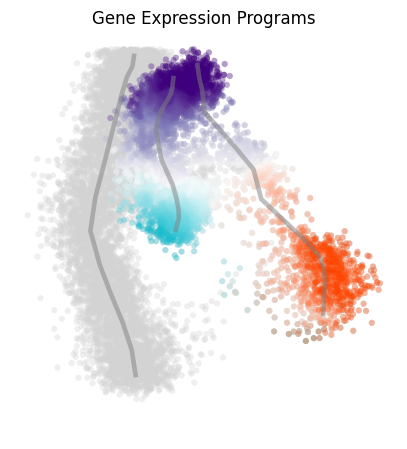

In [5]:
def custom_cmap(color, n = 256):
    colors = np.linspace([1, 1, 1], np.array(to_rgb(color)), n)
    return LinearSegmentedColormap.from_list(color, colors)

plt_list = [
    (['Snai1', 'Foxc1'], custom_cmap('tab:cyan'), .225, 'p98'),
    (['Sox2', 'Zeb2'], 'Purples', 2.225, 'p85'),
    (['Snai2', 'Twist1'], custom_cmap('orangered'), .35, 'p60')]

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
msk_src = (adata_plt.obs.source != 'GSE162534')
for (g, cmap, vmin, vmax) in plt_list:
    name = f'{'_'.join(g)}_Average'
    X_g = adata[:, g].X.toarray().mean(axis = 1)
    adata_plt.obs[name] = np.dot(nbr, X_g) / n_nbr
    msk_name = (adata_plt.obs[name] >= vmin)
    sc.pl.embedding(adata_plt[msk_src & msk_name],
                    'X_mesen', size = 80, alpha = .35,
                    color = name, vmin = vmin, vmax = vmax,
                    cmap = cmap, colorbar_loc = None,
                    frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title('Gene Expression Programs', size = 12)
ax.text(.5, -.05, ' ', ha = 'center', transform = ax.transAxes)
plt.savefig(os.path.join(pth_out, 'expression.pdf'), bbox_inches = 'tight')